# Homework 3
Kyle Schluns & Michael Streyle

## Notebook Setup

In [1]:
# Load useful libraries
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download data from Kaggle and unzip:

In [3]:
!mkdir /root/.kaggle

In [4]:
# NOTE: download your own kaggle.json file from Kaggle (your api key) and put it in the location below on your Google Drive
!cp "/content/drive/MyDrive/Colab Notebooks/E82/kaggle.json" "/root/.kaggle/kaggle.json"

In [5]:
!kaggle competitions download -c csci-e-82-2022
!unzip csci-e-82-2022.zip

 55% 9.00M/16.3M [00:00<00:00, 90.8MB/s]
100% 16.3M/16.3M [00:00<00:00, 135MB/s] 
Archive:  csci-e-82-2022.zip
  inflating: sample_solution.csv     
  inflating: test_data.csv           
  inflating: train_data.csv          


## Exploratory Data Analysis

Read in the data and display it.

In [6]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
train.head()

x1  x2  x3  x4          x5        x6        x7          x8        x9  \
0   0   0   0   1 -323.106605  2.694366 -1.987520  261.092784  0.013704   
1   0   0   0   1 -376.084691  0.969696 -6.933765  355.311648  0.030292   
2   0   0   0   0   91.955425  2.621643 -2.581162   51.357206  0.036668   
3   0   0   0   1 -391.814586  1.866914 -2.510799  382.900317  0.007947   
4   0   0   0   0 -363.823732  2.951346 -3.726368  330.527539  0.010074   

        x10  ...      z217      z218      z219       z220       z221  \
0  0.000100  ... -0.004930 -0.005554  5.246375  -7.534092   3.530736   
1 -0.000153  ...  0.022757  0.052506 -3.727741  -2.854443  -0.699268   
2 -0.000104  ... -0.086813 -0.101497 -7.510594  19.564182 -17.008130   
3 -0.000028  ...  0.030856 -0.161398 -6.435819   2.174453  -0.153956   
4 -0.000004  ... -0.017226 -0.016454 -2.581403   3.011932  -1.281361   

       z222  subject  phase  state  output  
0 -0.539045        K      3      C       1  
1 -0.054074        A      4      C       1  
2  4.945392        D      3      C       1  
3 -0.003958        G      2      C       0  
4  0.192647        C      2      C       1  

[5 rows x 670 columns]

Count the number of variables with any missing data. The fact that the table is empty means that there is no missing data in the train data.

In [7]:
train.isna().sum(axis=0).reset_index().rename(columns={'index':'var',0:'cnt'}).query('cnt > 0')

Empty DataFrame
Columns: [var, cnt]
Index: []

In [8]:
test.isna().sum(axis=0).reset_index().rename(columns={'index':'var',0:'cnt'}).query('cnt > 0')

Empty DataFrame
Columns: [var, cnt]
Index: []

The code below shows that there is data imbalance in the target variable `output`, such that 84.5% of the data are class `1` and the other 15.5% are class `0`. 

In [9]:
tmp = train['output'].value_counts().reset_index()
tmp.columns = ['output','count']
tmp['proportion'] = tmp['count']/tmp['count'].sum()
tmp

output  count  proportion
0       1   3873    0.844895
1       0    711    0.155105

For the categorical data, print group-level counts to check for data sparsity and group-level mean of `output` (which conveys how predictive a particular group might be). 

We find that there is only one sparse feature, which occurs for the `state` feature for group "E" since it only has 2 occurrences in the data.

Since the data is imbalanced where 84.5% of observations are class `1`, any mean `output` value that is statistically different from 84.5% will be a predictive feature. We can see that there are significant predictive power in the `subject` feature, and some minor predictive power in the other two features.

In [10]:
cat_cols = ['subject','phase','state']
for col in cat_cols:
  print(train.groupby(col)['output'].agg(['count','mean']),'\n')

         count      mean
subject                 
A          380  0.971053
B          513  0.859649
C          361  0.756233
D          420  0.938095
F          330  0.778788
G          518  0.492278
H          181  0.861878
I          663  0.962293
K          468  1.000000
L          444  0.912162
M          306  0.709150 

       count      mean
phase                 
1       1215  0.827160
2       1063  0.797742
3       1015  0.871921
4       1291  0.879163 

       count      mean
state                 
A        398  0.864322
B       1502  0.859521
C       2106  0.845204
D        576  0.791667
E          2  1.000000 



Let's split up the numeric columns (`train_num`), the categorical columns (`train_cat`), and the target variable (`train_y`).

In [11]:
train_num = train.iloc[:,:-4]
train_cat = train.iloc[:,-4:-1]
train_y = train['output']

Let's do the same for the test data.

In [12]:
test_num = test.iloc[:,:-3]
test_cat = test.iloc[:,-3:]

Now let's apply standard scaling to the numeric data and run PCA. We find the following conclusions:
- The first 20 components convey about 65% of the variance
- The first 100 components convey about 90% of the variance
- The first 200 components convey about 99% of the variance

This means we probably want to use somewhere between 100-200 PCA components for feature selection into a potential model. 

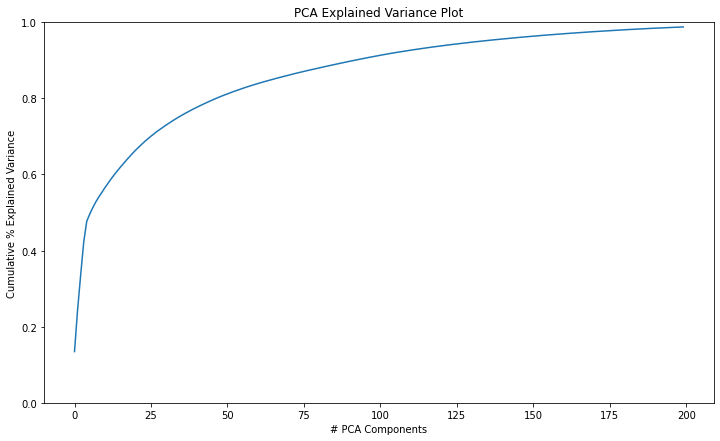

In [13]:
scaler = StandardScaler()
train_num_scaled = scaler.fit_transform(train_num)

pca_n_components = 200
pca = PCA(n_components=pca_n_components)
train_num_pca = pd.DataFrame(pca.fit_transform(train_num_scaled),columns=[f"pca{i+1}" for i in range(pca_n_components)])

pca_explained_var = pd.Series(pca.explained_variance_ratio_.cumsum()).reset_index()
pca_explained_var.columns = ['n_components','cum_explained_var']

fig = plt.figure(figsize=(12,7))
sns.lineplot(data=pca_explained_var,x='n_components',y='cum_explained_var')
plt.ylim([0,1])
plt.xlabel("# PCA Components")
plt.ylabel("Cumulative % Explained Variance")
plt.title("PCA Explained Variance Plot")
plt.show()

Let's apply the StandardScaler and PCA to the test data.

In [14]:
test_num_scaled = scaler.transform(test_num)
test_num_pca = pd.DataFrame(pca.transform(test_num_scaled),columns=[f"pca{i+1}" for i in range(pca_n_components)])

Now let's one-hot encode the categorical data and concatenate it with the 200 PCA numeric columns. We'll apply the encoder to both the train and test data.

NOTE: The test data has values in the `Subject` field which do not exist in the training data. These values are subjects "E" and "F". They make up over HALF of the rows in the test set! Therefore, we will set `handle_unknown` to "ignore" so that the OneHotEncoder does not fail when executed on the test data.

NOTE 2: We're going to elect not to drop any columns in the OneHotEncoder, meaning our one-hot encoded data will be singular (non-invertible matrix). This is fine for tree-based models, some regularized models, and any model that uses gradient descent. We will need to drop one column from each categorical variable if we ant to use it for a matrix-based ML algorithm. We elect to do this mainly so that we can try a model where we obscure the `Subject` field for a copy of the training data so that we can try to force the model not to rely too heavily on Subject.

In [15]:
ohe = OneHotEncoder(drop=None,handle_unknown="ignore")
train_cat_ohe = ohe.fit_transform(train_cat)
train_cat_ohe = pd.DataFrame(train_cat_ohe.toarray(),columns=ohe.get_feature_names_out())

test_cat_ohe = pd.DataFrame(ohe.transform(test_cat).toarray(),columns=ohe.get_feature_names_out())

train_concat = pd.concat([train_num_pca,train_cat_ohe],axis=1)
train_concat.head()

test_concat = pd.concat([test_num_pca,test_cat_ohe],axis=1)

Let's use the SelectKBest on all the columns and then apply a conservative threshold to only keep those with p-value < 0.05. This results in selecting 72 columns. Below we display the top 10 of both the most predictive features and the least predictive features. Based on the earlier EDA, it's no surprise that the categorical features are most important.

NOTE: The downside to using SelectKBest is that it doesn't account for any interactions between variables, so we should be sure to test models that test all the features at once and then use SHAP values to figure out which features are most important.

In [16]:
f_selector = SelectKBest(k="all")
train_concat_selected = f_selector.fit_transform(train_concat,train_y)

p_threshold = 0.05
best_k = (f_selector.pvalues_ < p_threshold).sum()
print(f"SelectKBest found {best_k} features with p_value < {p_threshold}")
f_selector = SelectKBest(k=best_k)
train_concat_selected = f_selector.fit_transform(train_concat,train_y)
train_concat_selected = pd.DataFrame(train_concat_selected,columns=f_selector.get_feature_names_out())

f_selector_col_idx = {col:i for i, col in enumerate(train_concat.columns) if col in train_concat_selected.columns}
f_selector_scores = [{'col':col, 'score':f_selector.scores_[idx], 'pvalue': f_selector.pvalues_[idx]}  for col, idx in f_selector_col_idx.items()]
f_selector_scores = pd.DataFrame(f_selector_scores)
f_selector_scores.sort_values("score",ascending=False).head(10)

SelectKBest found 53 features with p_value < 0.05


col       score         pvalue
43  subject_G  630.009214  2.227797e-130
45  subject_K   97.680711   8.300224e-23
44  subject_I   82.956959   1.226185e-19
39  subject_A   50.858923   1.148009e-12
47  subject_M   46.552758   1.008026e-11
2        pca3   33.081708   9.411036e-09
41  subject_D   30.839719   2.960796e-08
3        pca5   30.451125   3.612514e-08
1        pca2   25.368775   4.917160e-07
40  subject_C   23.617124   1.214631e-06

In [17]:
f_selector_scores.sort_values("score",ascending=False).tail(10)

col     score    pvalue
25   pca106  4.951912  0.026110
19    pca58  4.917697  0.026632
32   pca146  4.740280  0.029515
14    pca43  4.656297  0.030992
37   pca187  4.270988  0.038824
7     pca17  4.165463  0.041313
11    pca38  4.125562  0.042298
21    pca78  4.038985  0.044519
48  phase_1  3.969455  0.046392
8     pca23  3.899240  0.048368

Now let's do some further EDA to visualize the predictive power for some of the top features identified by SelectKBest. It's worth restating that anything significantly different from the observed overall probability of class `1` in the `output` variable (84.5%) is likely going to be a predictive feature.

This is pretty easily observed in the two categorical features. For the numeric features `pca3` and `pca5`, you can see that they are weak predictors because only the small and large values of the features have distinctly different `output` values compared to the baseline of 84.5%. It is our hope that if we combine many of these weakly predictive features, that the model could be strong. 

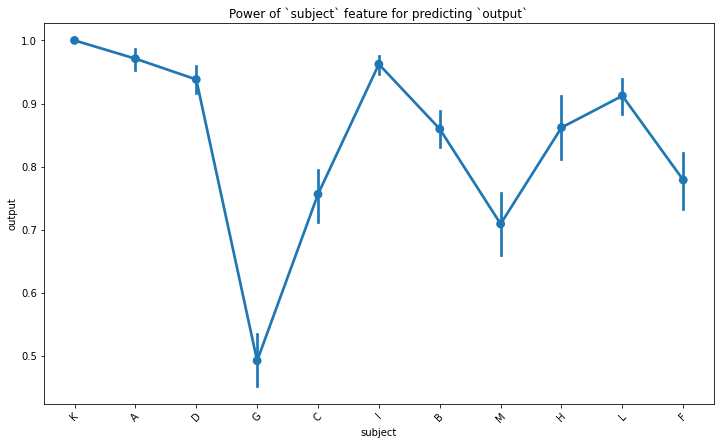

In [18]:
col = 'subject'
fig = plt.figure(figsize=(12,7))
sns.pointplot(x=train[col],y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of `{col}` feature for predicting `output`")
plt.show()

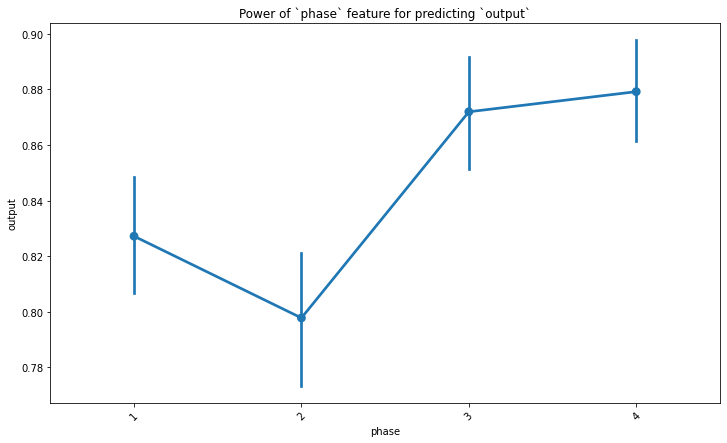

In [19]:
col = 'phase'
fig = plt.figure(figsize=(12,7))
sns.pointplot(x=train[col],y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of `{col}` feature for predicting `output`")
plt.show()

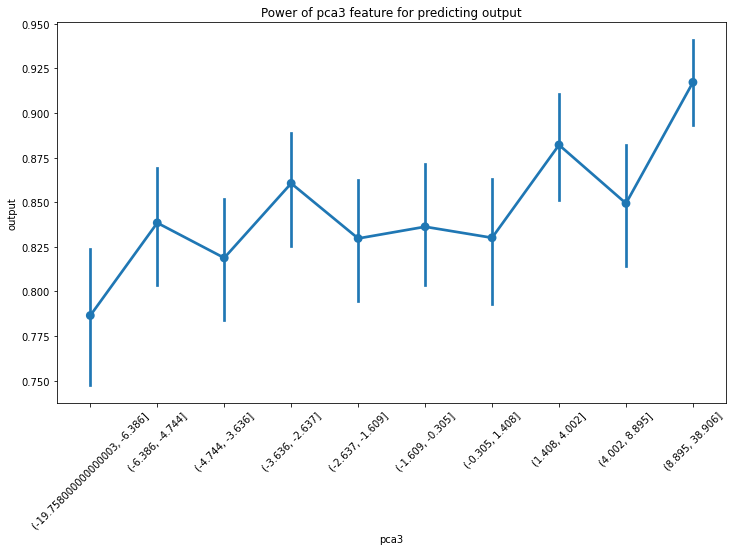

In [20]:
col = 'pca3'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

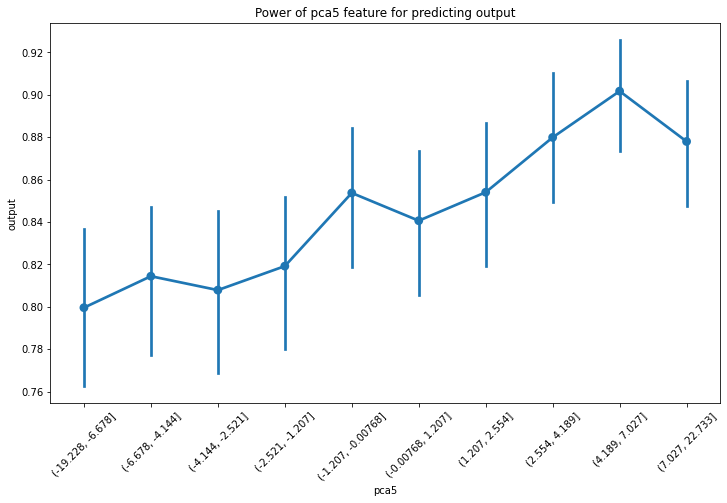

In [21]:
col = 'pca5'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

Now look at the two weakest predictors as determined by SelectKBest: `pca160` and `pca23`. To no surprise, these are even weaker features, but they could be useful when combined with others in a large model.

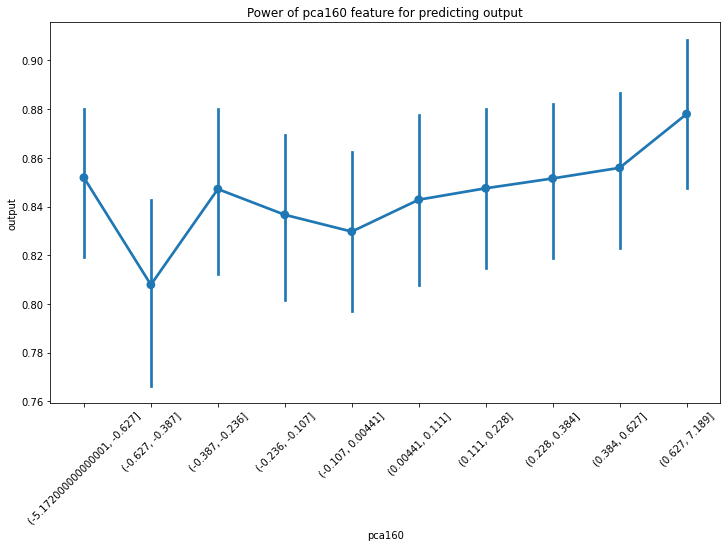

In [22]:
col = 'pca160'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

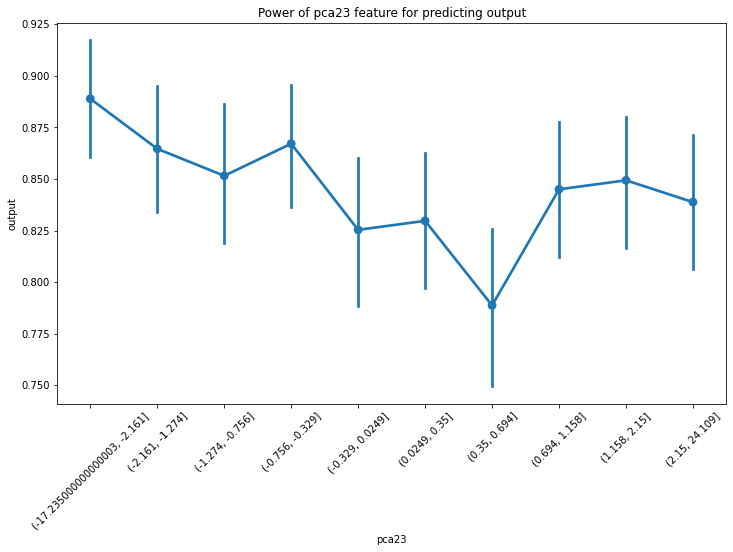

In [23]:
col = 'pca23'
feature_bin = pd.qcut(train_concat[col],q=10,duplicates="drop")

fig = plt.figure(figsize=(12,7))
sns.pointplot(x=feature_bin,y=train_y)
plt.xticks(rotation=45)
plt.title(f"Power of {col} feature for predicting output")
plt.show()

## Modeling Strategy

Let's use this space to brainstorm ideas for what model frameworks we should attempt:

Kyle
- Random Forest classifier will likely perform best
- Logistic regression would be useful as a baseline model

Michael
- XGboost classifier
- Could test impact of limiting features going into model based on the SelectKBest
- Could test impact of combining SMOTE and random undersampling (as mentioned [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/))
- Utilize UMAP to visualize dimensionality reduction

## Random Forest classifier

Let's create a version of the training data where we:
1. Make a copy of the train data
2. Set the one-hot encoded `subject` fields in the copied data to all zeros (let's call this data the "obscured" set)
3. Concatenate the original train data with the obscured train data into one big training set

In [24]:
cols = [c for c in train_cat_ohe.columns if 'subject' in c]

train_cat_unknown_subject = train_cat_ohe.copy()
train_cat_unknown_subject[cols] *= 0.0

train_concat_obscurred = pd.concat([train_num_pca,train_cat_unknown_subject],axis=1)
train_concat_obscurred = pd.concat([train_concat,train_concat_obscurred],axis=0,ignore_index=True)

train_y_obscurred = pd.concat([train_y,train_y],ignore_index=True)

Here's some commented out code to tune the hyperparameters with RandomizedSearchCV, but this was taking too long to run so skipping this for now.

In [25]:
# NOTE: Commented this CrossValidation section out as it was taking FOREVER to run and not providing a lot of value because all the parameters were producing the same validation metrics

# n_estimators = [100,200,400]
# max_features = ['sqrt']
# max_depth = [5,10,15]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# search_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
               
# rf = RandomForestClassifier(random_state=0)
# clf_cv = RandomizedSearchCV(rf, search_grid, n_iter = 25, cv = 3, verbose=1, random_state=42)

# clf_cv.fit(train_concat,train_y)

Let's split train/test so we can get some sense of under/over fitting without needing to use up one of our Kaggle submissions to do so. 

We'll do this for both the original training data and the original+obscurred training data.


In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_concat, train_y, test_size=0.2, random_state=42)
X_train_obscurred, X_test_obscurred, y_train_obscurred, y_test_obscurred = train_test_split(train_concat_obscurred, train_y_obscurred, test_size=0.2, random_state=42)

Let's train the first model on the original training data.

In [27]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=5, random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_features='sqrt', random_state=42)

And now train the second model on the original+obscurred data.

In [28]:


clf_obscurred = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=5, random_state=42)
clf_obscurred.fit(X_train_obscurred,y_train_obscurred)

RandomForestClassifier(max_depth=5, max_features='sqrt', random_state=42)

Let's now make predictions on our train/test sets for both models and output the AUC scores.

In [29]:
pred_train = clf.predict_proba(X_train)
pred_test = clf.predict_proba(X_test)

pred_train_obscurred = clf_obscurred.predict_proba(X_train_obscurred)
pred_test_obscurred = clf_obscurred.predict_proba(X_test_obscurred)

print("Model fit on Original Data:")
print(f"\ttrain:\t{roc_auc_score(y_train,pred_train[:,1]):0.3f}")
print(f"\ttest:\t{roc_auc_score(y_test,pred_test[:,1]):0.3f}")
print("Model fit on Original+Obscurred Data:")
print(f"\ttrain:\t{roc_auc_score(y_train_obscurred,pred_train_obscurred[:,1]):0.3f}")
print(f"\ttest:\t{roc_auc_score(y_test_obscurred,pred_test_obscurred[:,1]):0.3f}")

Model fit on Original Data:
	train:	0.939
	test:	0.810
Model fit on Original+Obscurred Data:
	train:	0.912
	test:	0.815


Now let's run predictions on the submission data, download it from the notebook, and submit in Kaggle!

In [30]:
test_preds = clf.predict_proba(test_concat)[:,1]
pd.DataFrame({'output':test_preds},index=test_concat.index).reset_index().rename(columns={"index":"id"}).to_csv("submission_original.csv",index=False)

In [31]:

test_preds_obscurred = clf_obscurred.predict_proba(test_concat)[:,1]
pd.DataFrame({'output':test_preds_obscurred},index=test_concat.index).reset_index().rename(columns={"index":"id"}).to_csv("submission_original+obscurred.csv",index=False)

Let's visualize the first tree in the forest for the model trained only on the original data.

In [32]:
estimator = clf.estimators_[0]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns.tolist(),
                class_names = ["0","1"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

In [33]:
estimator = clf_obscurred.estimators_[0]
export_graphviz(estimator, out_file='tree_obscurred.dot', 
                feature_names = X_train_obscurred.columns.tolist(),
                class_names = ["0","1"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree_obscurred.dot', '-o', 'tree_obscurred.png', '-Gdpi=600'])
Image(filename = 'tree_obscurred.png')